## Purpose for this notebook: Learn from the professional user in kaggle

#### Once you have understand the theory of data science, it is not easy for you to apply it on a real-world problem
#### Kaggle got many experts and they did it very well. This notebook is aimed to demostrate how they work on the EDA
#### about the house price data set. I just follow how the editor(DOMINIK GAWLIK) analyse the data step by step and 
#### add some code for me to understand more why they will do it.
#### It is a good chance to understand more about how I can apply what I have learnt.
--------------------------------------------------------------------------------------------------------
#### Data set used: House Pirce

#### Reference: https://www.kaggle.com/dgawlik/house-prices-eda/notebook

In [1]:
# simple setting for background

%matplotlib inline
import numpy as np
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import warnings # Hide the warning for sns.distplot
warnings.filterwarnings('ignore') # Not suggest since it may ignore critical warning

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Checking for missing column by compariing training and testing set

def check_duplicate_column(train, test):
    return train.columns[train.columns.isin(test.columns) == False]

In [3]:
# Read the data
test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')

In [4]:
check_duplicate_column(train, test)

Index(['SalePrice'], dtype='object')

#### First Step: Classify the type for each columns

In [5]:
# Classify the quantitative and qualitative columns
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('Id') # Remove the columns that's not estiential
quantitative.remove('SalePrice') # Remove the target
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

#### Second Step: Determine the missing number for each features

<AxesSubplot:>

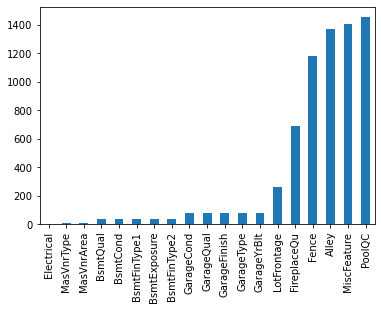

In [6]:
# Showing that 19 attributes have missing values
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar()

Show that 19 attributes got missing value and we have to consider how to fill it up such as
classifying it as missing in their catergorials or tried it drop it out but those important information
will be lost. Also, using one-hot encoding will generate more column/ dimension and it is not good
for having the prediction model since it will increase the chance for overfiting

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

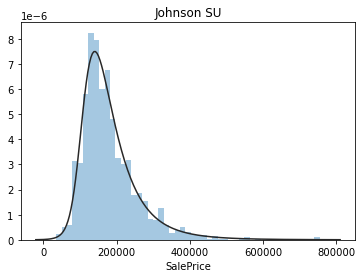

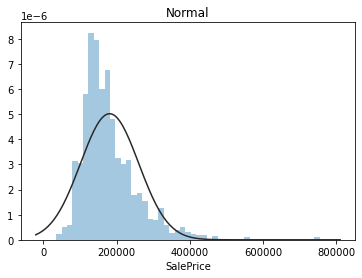

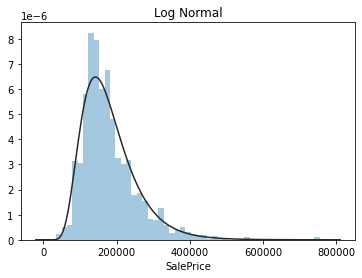

In [7]:
# Determine the distribution by using the visualization of histogram and line plot

import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde = False, fit = st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde = False, fit = st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde = False, fit = st.lognorm)

To determine the distribution for SalePrice, distplot was used to compare the line and histogram. From the graph, we know that the data is not fit by using normal distribution. We can see that it is fit for log normal distribution and it is perfectly fit to johnson distribution.

In [8]:
# Check all the quantitative variables has normal distribution or not
test_normality = lambda x: st.shapiro(x.fillna(0))[1] < 0.01 # checking with the p-value
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


Also, none of the quantitative variables has normal distribution by using the shapiro function. Therefore, the data needed to be transformed.

The stats.shapiro() function is testing the data set. The H0 (null hypothesis) will be the data was drawn from normal distribution.

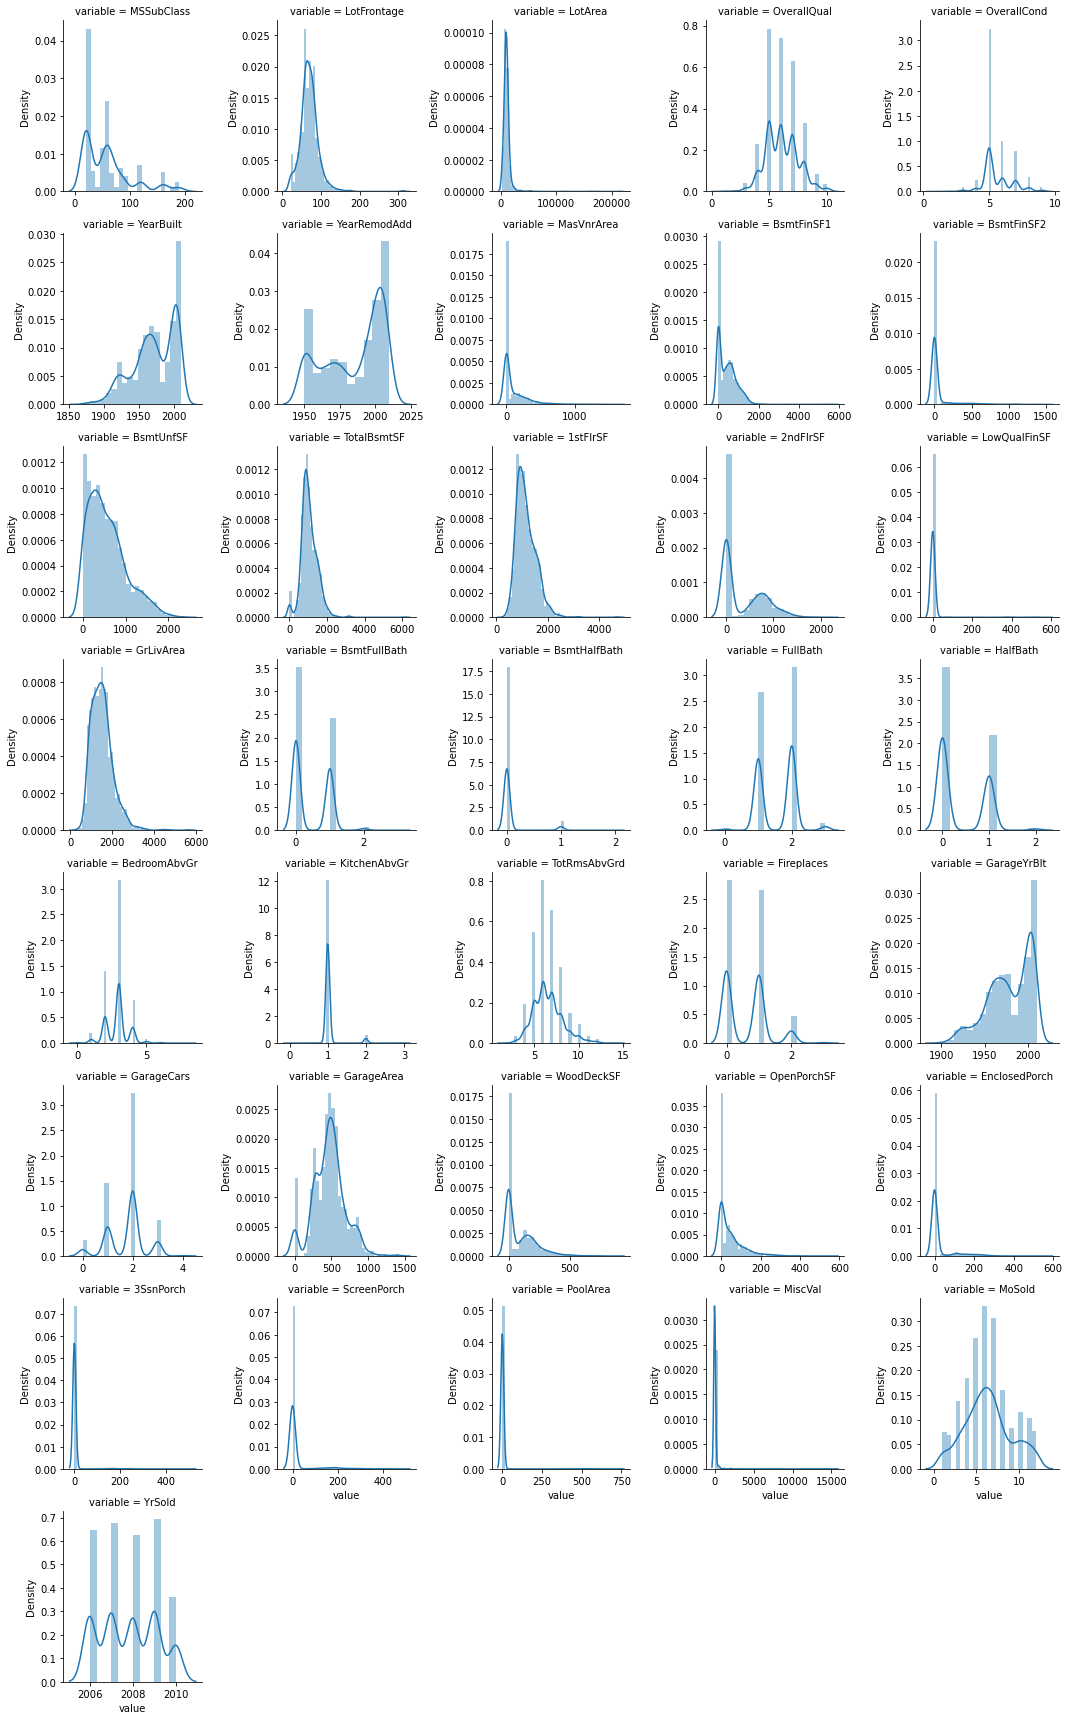

In [9]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

According to the editor, these variable: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea is good for using the log transformation. 

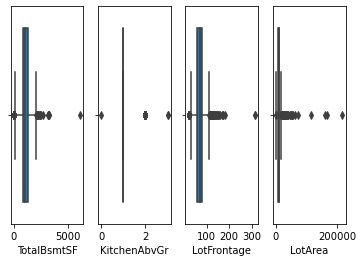

In [10]:
variable_for_checking = ['TotalBsmtSF', 'KitchenAbvGr', 'LotFrontage', 'LotArea']
for i, v in enumerate(variable_for_checking):
    plt.subplot(1,4,i+1)
    sns.boxplot(train[v])

By checking the data in these variables, boxplot was used and some outlier was observed.
To eliminate the effect from outlier, the log transformation can help to minimize the effect and give a better distribution for further analysis/ model training

After checking the quantitative variables, quanlitative variables will be visualized by using the boxplot
and comparing with target quantitative variables.

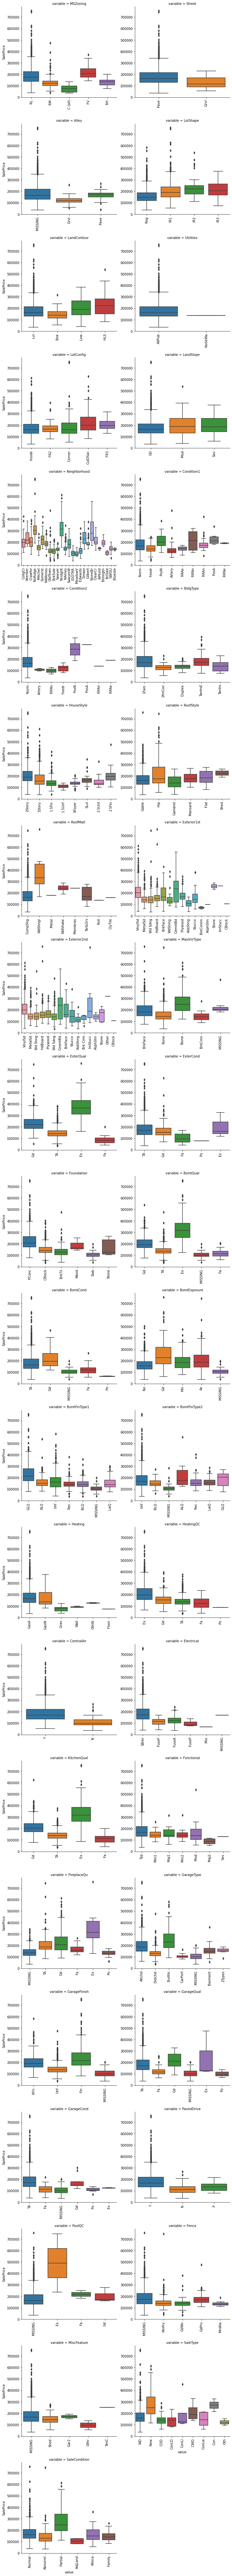

In [11]:
# Create the missing value for some qualitative variables
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')
        
def boxplot(x, y, **kwargs):
    sns.boxplot(x = x, y = y)
    x=plt.xticks(rotation = 90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex= False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'SalePrice')

Some categories is more diverse with respect to SalePrice than others. Neighbourhood got a great impact towards the SalePrice. Also, pool will be critical for high price. Partial SaleCondition will be most expensive.

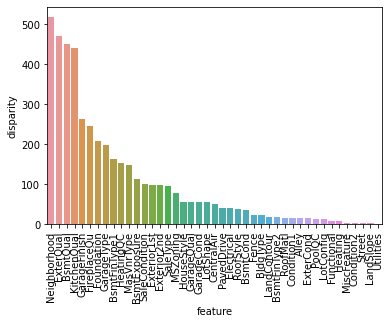

In [12]:
# Define the anova function and check with the train data
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x = 'feature', y = 'disparity')
x=plt.xticks(rotation=90)

Just a quick estimation of influence of categorical variable on SalePrice. ANOVA was used to detemine is there any difference or same distribution between group mean with f-test. Therefore, stats.f_oneway was used for ANOVA testing (analysis of variance). If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing  diversity in partitions.

In [13]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
        
qual_encoded = []
for q in qualitative:
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


Now qualitative variables get encoded according to ordering based on mean of SalePrice. We can check that the variable was encoded will generate the column in dataset and changed to rank/ numeric value. It helps to provide more information for the model that we are going to apply.

In [14]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,1,60,RL,65.0,8450,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
1,2,20,RL,80.0,9600,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
2,3,60,RL,68.0,11250,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
3,4,70,RL,60.0,9550,Pave,MISSING,IR1,Lvl,AllPub,...,3.0,2.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,2.0
4,5,60,RL,84.0,14260,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0


### Correlations

In this section, spearman's rank correlation was used.

It said that the variable that uncorrelated to each other but correlated with SalePrice should be added to the regression model to reduce the confunding.

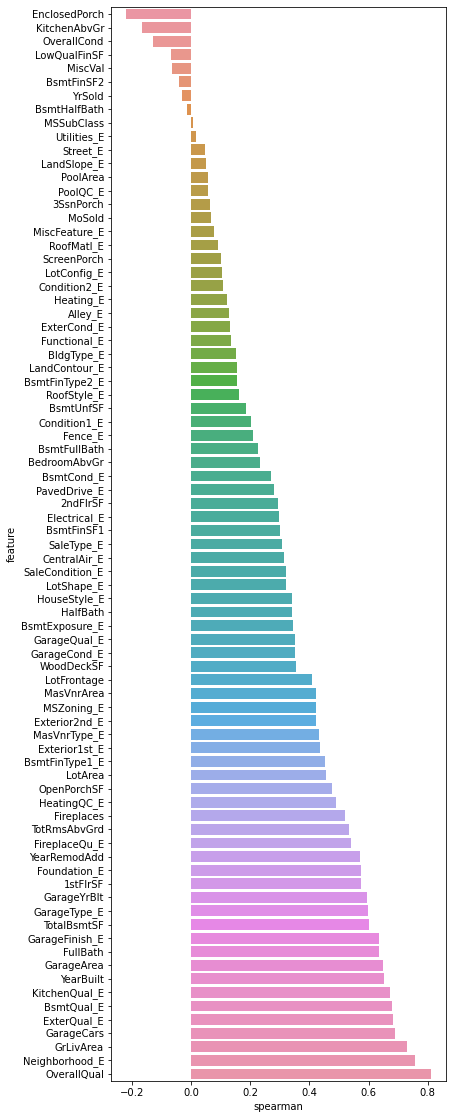

In [15]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize = (6, .25 * len(features)))
    sns.barplot(data = spr, y = 'feature', x = 'spearman', orient = 'h')
    
features = quantitative + qual_encoded
spearman(train, features)

Spearman correlation was used since it also pick up the relationsips between variables even they are nonlinear. By taking look for the plot, the OverallQual will be the major criteria towards the house price. 

<AxesSubplot:>

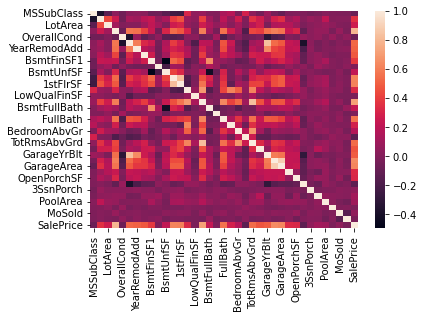

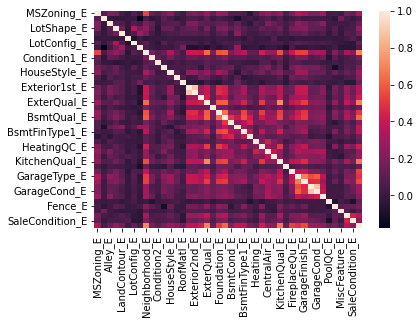

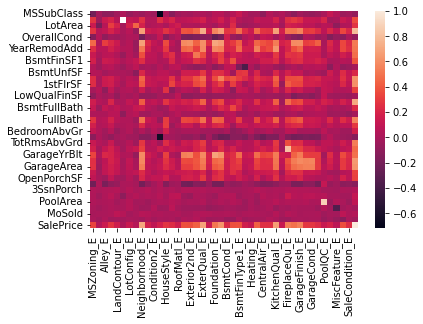

In [16]:
# Focusing on the correlation of all parameters towards the House Sale Price
# Work on the first graph in plt figure
plt.figure(1)
# DataFrame correlation can be calculated by using the corr function
# Showing the correlation of quantitative value
corr = train[quantitative + ['SalePrice']].corr()
# Put the corr table for seaborn to generate a heat map for visualization
sns.heatmap(corr)
# Work on the second graph in plt figure
plt.figure(2)
# Showing the corrleation of encoded qualitative value
corr = train[qual_encoded +['SalePrice']].corr()
sns.heatmap(corr)
# Work on the third graph in plt figure
plt.figure(3)
# Showing the correlation of quanlitative and quantitative value
# Create a data frame with quantitative value as index/ row and encoded qualitative value as column
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded) + 1]), index = quantitative + ['SalePrice'], columns = qual_encoded + ['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        # Assign the coresponding location for the correation for those values
        # Get rid of some information that's replicate from the previous two graph
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

It's hard to take a look on the heatmap and the style of the heatmap needed to be changed to have a better observation.

Try to get rid of the red color and we can observe some strong relation for the white and black color. For the Garage area was corrlated to the build year. Also, the basement unit and the first floor was also correlated.

From the thrid graph, there is a pink stragint in the neighborhood and that's mean it is correlated to many different variables.

##### Pairplot

From Kaggle editor, it is the part to see how sale price compares to each independent variable. We may observe some pattern that we can apply the quadratic term to regression. Also, some nonlinearties variable will not be selected by Lasso/Lars.

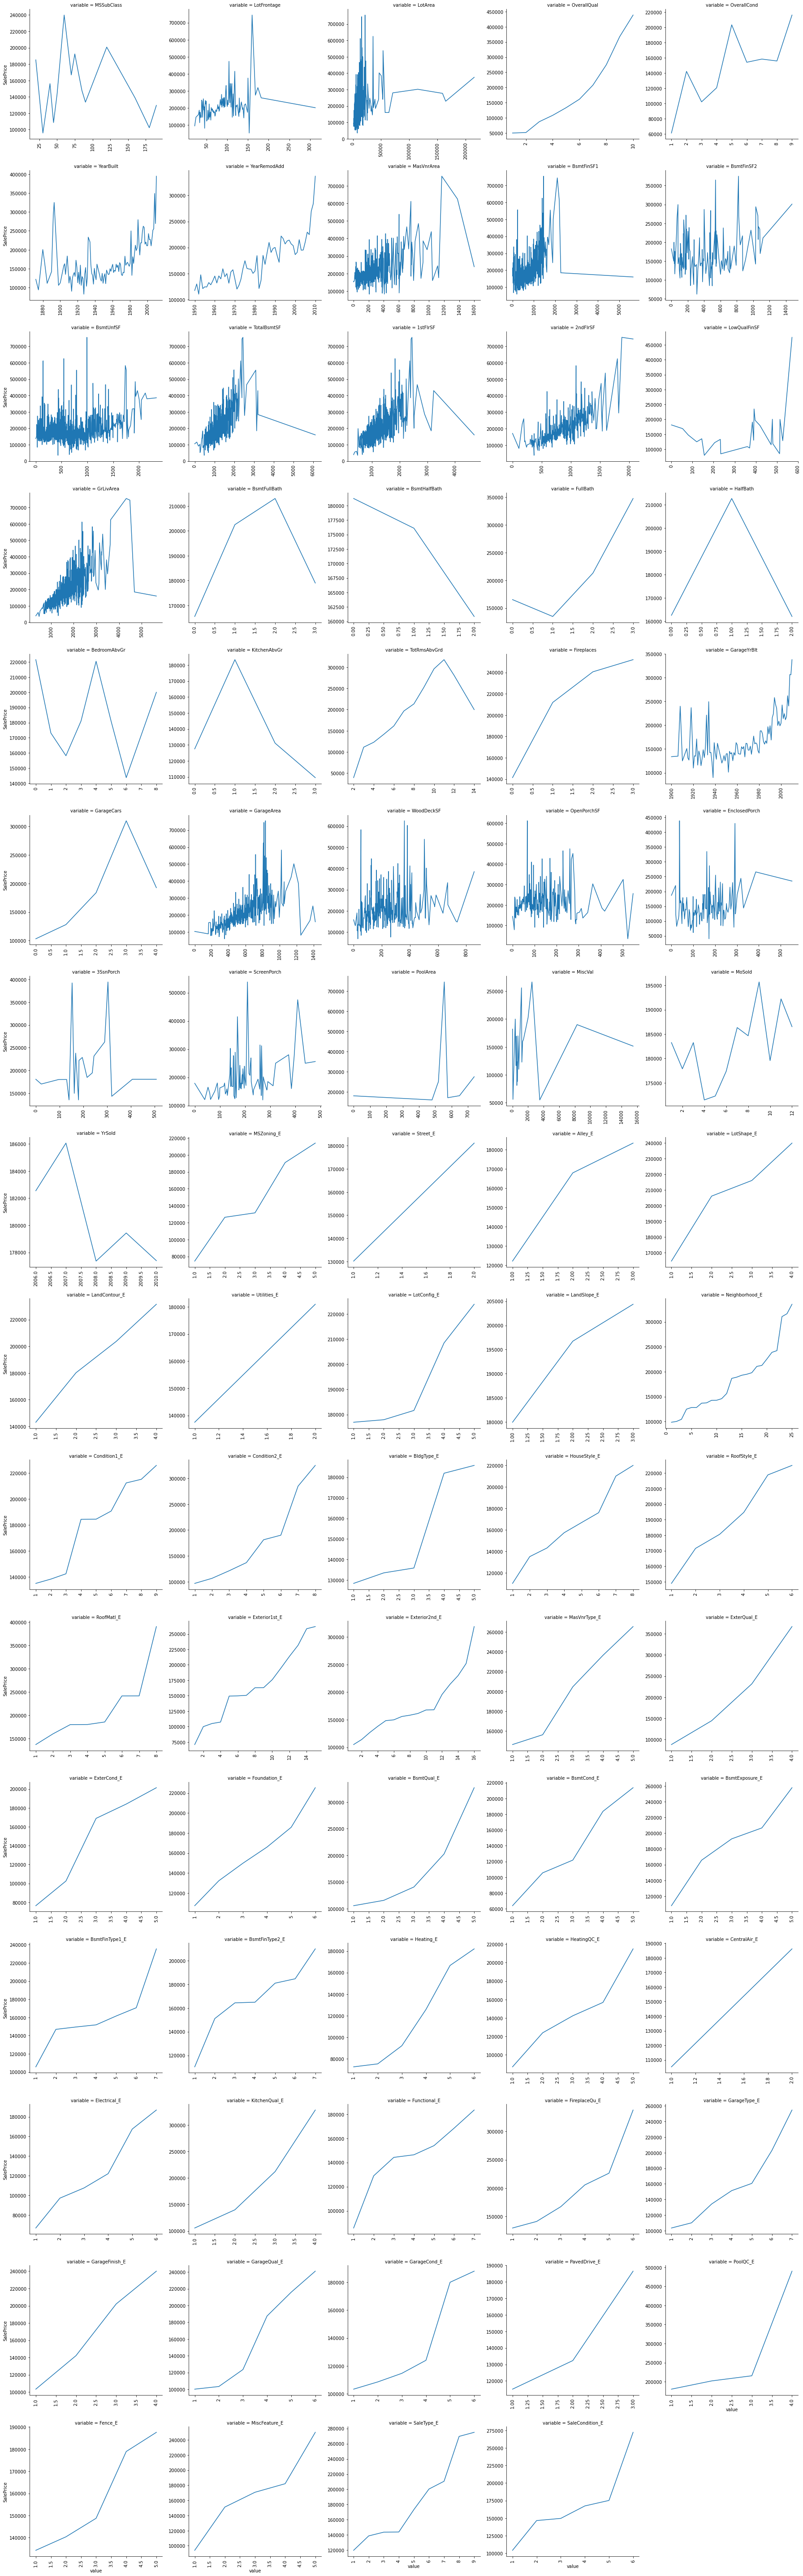

In [18]:
def pairplot(x , y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax= ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars =['SalePrice'], value_vars = quantitative + qual_encoded)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5, sharex = False, sharey = False, size =5)
g = g.map(pairplot, 'value', 'SalePrice')

For some variables, there is no linearity towards the sale price and it wont be selected by Lasso/ Lars. Some factors like Year Built, 1stFlrSF would benefit from adding quafratic term to regression. It will also provoke overfit as well. The pattern that we can observed is that it got a fluctuation in narrow range of variable towards the saleprice. That means it may not be able to be explained by using the simple linear function.

##### Price Segments

Try to form some group with a price cutoff to check with the position different for some parameters.

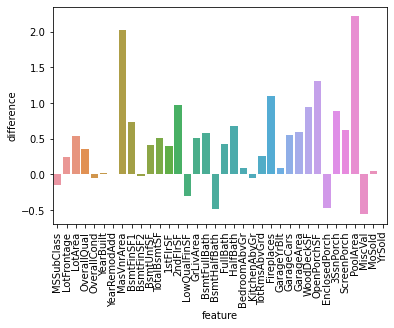

In [20]:
features = quantitative
# Using 200000 as a cutoff for standard and pricey group
standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

# Create an empty data frame
diff = pd.DataFrame()
diff['feature'] = features
# Calculate the mean for each group and calculate the differnet portion
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/ (standard[f].fillna(0.).mean()) for f in features]
sns.barplot(data = diff, x = 'feature', y='difference')
x = plt.xticks(rotation = 90)

Try to divided the house price into two groups and compare the mean variables. The cutoff can be adjusted as well to give different information. 

In [21]:
diff.sort_values('difference')

,feature,difference
33,MiscVal,-0.559517
17,BsmtHalfBath,-0.487756
29,EnclosedPorch,-0.479096
14,LowQualFinSF,-0.298300
0,MSSubClass,-0.150366
21,KitchenAbvGr,-0.050115
4,OverallCond,-0.047635
9,BsmtFinSF2,-0.023328
35,YrSold,-0.000021
6,YearRemodAdd,0.010197


There is a big difference for PoolArea, MasVnrArea and OpenPorchSf in expensive house and it can be a critical parameters for the determination of House Price.